In [13]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
import operator
from langchain_core.messages import SystemMessage, HumanMessage
import os

api_key = os.getenv('GROQ_API_KEY')
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=api_key)
load_dotenv()

True

In [14]:
generator_llm = llm
evaluator_llm = llm
optimizer_llm = llm

In [15]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "need_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="Constructive feedback for tweet.")

In [16]:
structured_evaluation_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [17]:
#state
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "need_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]
    

In [18]:
def generate_tweet(state: TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator llm
    response = generator_llm.invoke(messages).content

    # return respone
    return {'tweet': response, 'tweet_history': [response]}

In [19]:
def evaluate_tweet(state: TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content=f"""
        Evaluate the following tweet:

        Tweet: "{state['tweet']}"

        Use the criteria below to evaluate the tweet:

        1. Originally - Is this fresh, or have you seen it a hundred times before?
        2. Humor - Did it genuinely make you smile, laugh, or chuckle?
        3. Punchiness - It is short, sharp, and scroll-stopping?
        4. Virality Potential - would people retweet or share it?
        5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 200 characters)?

        Auto-reject if:
        - It's written in question-answer format (e.g, "Why did..." or "What happens when...")
        - It exceeds 280 characters
        - It reads like a traditional setup-punchline joke
        - Don't end with generic, throwaway, or deflating lines that weaken the humor (e.g, "Masterpieces of the auntie-unlce universe" or vague summaries)

        ### Respond ONLY in structured format:
        - evaluation: "approved" or "needs_improvement"
        - feedback: One paragraph explaining the strengths and weaknesses
        """)
    ]

    response = structured_evaluation_llm.invoke(messages)

    return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [20]:
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content = f"""
        
        Improve the tweet based on this feedback:
        "{state['feedback']}"

        Topic: "{state['topic']}"
        Original Tweet:
        {state['tweet']}

        Rewrite it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
        """)
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [21]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'need_improvement'

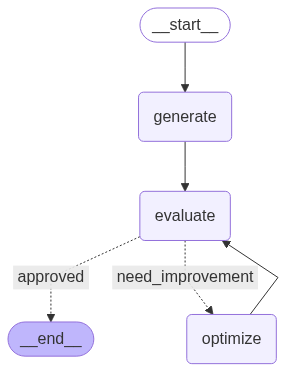

In [22]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'need_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()
workflow


In [25]:
initial_state = {
    "topic": "Railways",
    "iteration": 1,
    "max_iteration": 5
}

result=workflow.invoke(initial_state)
result

{'topic': 'Railways',
 'tweet': '"Just spent 3 hours on a train with a guy who\'s been playing the same 10-second clip of \'Baby Shark\' on a loop. Train delays are just a form of sonic punishment #RailwayLife #BabySharkForever"',
 'evaluation': 'approved',
 'feedback': "This tweet effectively utilizes the 280 character limit, employs a well-structured and concise format, and has a clear narrative. The humor is present in the relatable scenario and clever use of 'sonic punishment', making it engaging and likely to elicit a chuckle. However, the tweet could benefit from a touch more originality, as this type of anecdote is not uncommon. The hashtags #RailwayLife and #BabySharkForever are a good addition, potentially increasing the tweet's virality.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['"Just spent 3 hours on a train with a guy who\'s been playing the same 10-second clip of \'Baby Shark\' on a loop. Train delays are just a form of sonic punishment #RailwayLife #Baby

In [26]:
for tweet in result['tweet_history']:
    print(tweet)

"Just spent 3 hours on a train with a guy who's been playing the same 10-second clip of 'Baby Shark' on a loop. Train delays are just a form of sonic punishment #RailwayLife #BabySharkForever"
